In [ ]:
!pip install segmentation-models-pytorch
!git clone https://github.com/anshulvvv/Dataset-For-Image-Segmentation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [25]:
!mv /content/Dataset-For-Image-Segmentation /content/Human-Segmentation-Dataset-master

In [26]:
TRAIN_CSV = '/content/Human-Segmentation-Dataset-master/train.csv'
BASE_DIR = '/content'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 20
lr_rate = 0.001
IMG_DIM = 320
batch_size = 24
ENCODER_NAME = 'timm-efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'

In [27]:
df = pd.read_csv(TRAIN_CSV)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [28]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=57)


In [29]:
import albumentations as A
def train_aug():
    return A.Compose([
        A.Resize(IMG_DIM, IMG_DIM),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)
def valid_aug():
    return A.Compose([
        A.Resize(IMG_DIM, IMG_DIM)
    ], is_check_shapes=False)


In [30]:
from torch.utils.data import Dataset

In [31]:
class SegDataset(Dataset):
    def __init__(self, dataframe, transforms):
        self.data = dataframe
        self.transforms = transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        record = self.data.iloc[idx]
        img_file = record.images
        mask_file = record.masks
        image = cv2.imread(img_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image) / 255.0
        mask = torch.round(torch.tensor(mask) / 255.0)
        return image, mask

In [32]:
train_set = SegDataset(df_train, train_aug())
valid_set = SegDataset(df_valid, valid_aug())
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(valid_set)}")

Train set size: 232
Validation set size: 58


In [33]:
from torch.utils.data import DataLoader

In [34]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [35]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [36]:
class SegModel(nn.Module):
    def __init__(self):
        super(SegModel, self).__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER_NAME,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)
    def forward(self, imgs, masks=None):
        out = self.model(imgs)
        if masks is not None:
            loss_dice = DiceLoss(mode='binary')(out, masks)
            loss_bce = nn.BCEWithLogitsLoss()(out, masks)
            return out, loss_dice + loss_bce
        return out

In [37]:
seg_model = SegModel()
seg_model.to(device)

SegModel(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmo

In [38]:
def train_model(loader, model, optimizer):
    total_loss = 0.0
    model.train()
    for imgs, masks in tqdm(loader):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        output, loss = model(imgs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [39]:
def eval_model(loader, model):
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for imgs, masks in tqdm(loader):
            imgs = imgs.to(device)
            masks = masks.to(device)
            output, loss = model(imgs, masks)
            total_loss += loss.item()
    return total_loss / len(loader)

In [40]:
optimizer = torch.optim.Adam(seg_model.parameters(), lr=lr_rate)

In [41]:
best_val_loss = 1e9

In [42]:
for i in range(num_epochs):
    tr_loss = train_model(train_loader, seg_model, optimizer)
    val_loss = eval_model(valid_loader, seg_model)
    if val_loss < best_val_loss:
        torch.save(seg_model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")
        best_val_loss = val_loss
    print(f"Epoch {i+1} Train Loss {tr_loss} Val Loss {val_loss}")

100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


MODEL SAVED
Epoch 1 Train Loss 1.0945533156394958 Val Loss 2.2733868757883706


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


MODEL SAVED
Epoch 2 Train Loss 0.579733794927597 Val Loss 0.6127619942029318


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


MODEL SAVED
Epoch 3 Train Loss 0.42389771044254304 Val Loss 0.4441585640112559


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


MODEL SAVED
Epoch 4 Train Loss 0.32974656820297243 Val Loss 0.32320161660512287


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


MODEL SAVED
Epoch 5 Train Loss 0.26504095643758774 Val Loss 0.3072359561920166


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


MODEL SAVED
Epoch 6 Train Loss 0.22986637353897094 Val Loss 0.26152286926905316


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


MODEL SAVED
Epoch 7 Train Loss 0.23644588887691498 Val Loss 0.224971741437912


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 8 Train Loss 0.20932702869176864 Val Loss 0.2813875575860341


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


MODEL SAVED
Epoch 9 Train Loss 0.17472617626190184 Val Loss 0.22166022658348083


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


MODEL SAVED
Epoch 10 Train Loss 0.19647739380598067 Val Loss 0.22109206020832062


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch 11 Train Loss 0.1914489150047302 Val Loss 0.24348349372545877


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch 12 Train Loss 0.14527280777692794 Val Loss 0.22701790928840637


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 13 Train Loss 0.12439018785953522 Val Loss 0.2742284834384918


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


MODEL SAVED
Epoch 14 Train Loss 0.12002942711114883 Val Loss 0.20693451166152954


100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


MODEL SAVED
Epoch 15 Train Loss 0.10608557611703873 Val Loss 0.18917174140612283


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch 16 Train Loss 0.12898371294140815 Val Loss 0.19911761085192362


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


MODEL SAVED
Epoch 17 Train Loss 0.1053731195628643 Val Loss 0.18732179701328278


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


MODEL SAVED
Epoch 18 Train Loss 0.0923556186258793 Val Loss 0.1830862561861674


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


MODEL SAVED
Epoch 19 Train Loss 0.08589049875736236 Val Loss 0.16544907043377557


100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

Epoch 20 Train Loss 0.08184720501303673 Val Loss 0.23452040801445642


In [ ]:
seg_model.load_state_dict(torch.load("best_model.pt"))

In [44]:
def infer_sample(idx):
    img, mask = valid_set[idx]
    pred = seg_model(img.to(device).unsqueeze(0))
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    return img, mask, pred

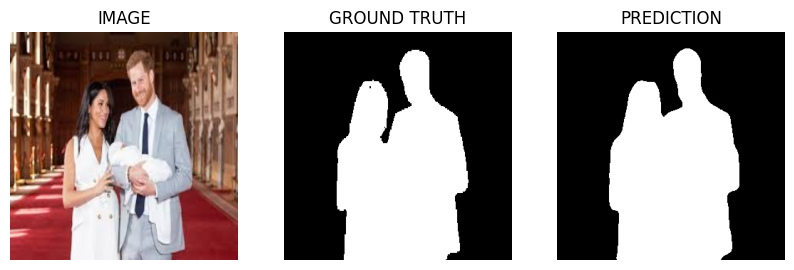

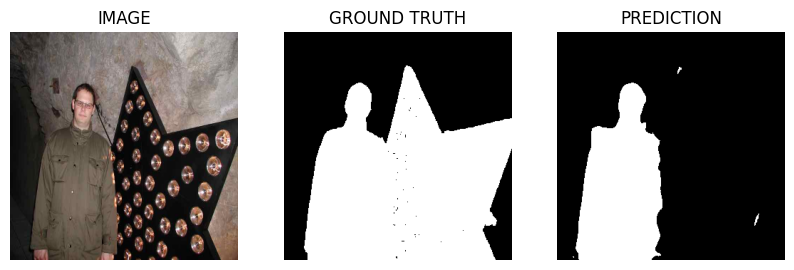

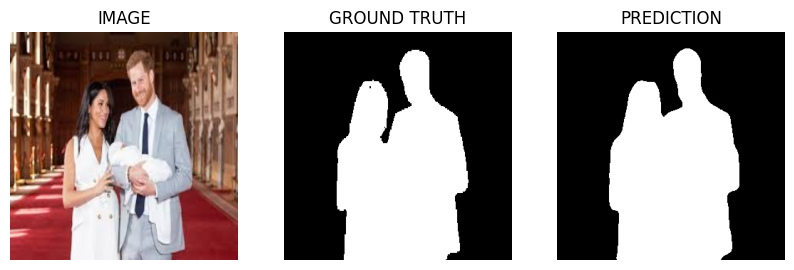

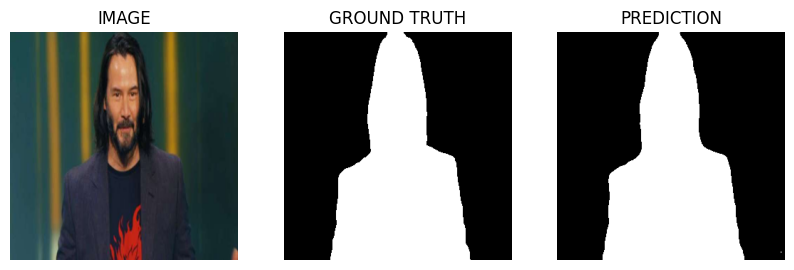

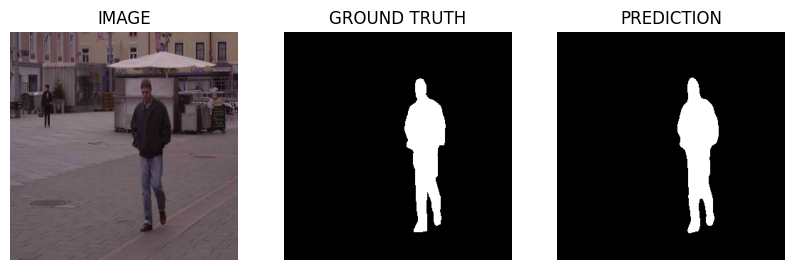

In [47]:
for i in np.random.randint(0, len(valid_set), 5):
    img, mask, prediction = infer_sample(i)
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.title('IMAGE')
    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(mask, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH')
    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(prediction.detach().cpu().squeeze(0), (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION')